# MLP Implementation with ADAM Optimizer
### A code that implements MLP with multiple layers
By Isu Kim @ https://github.com/isu-kim

In [1]:
import numpy as np
import random

In [2]:
import random


def train_validate_split(x, y, train_percentage):
    """
    A function that splits train data and validate data with given ratio
    
    @param x: The list of x.
    @param y: The list of y.
    @param train_percentage: The total train data's percentage. 0.8 for 80%
    @return: tuple in train_x, train_y, validate_x, validate_y
    """
    all_data = [i for i in range(len(x))]
    selected = list()
    for i in range(int(train_percentage * len(x))):
        choice = random.choice(all_data)
        selected.append(choice)
        all_data.remove(choice)
    
    print("Total Train : " + str(len(selected)) + " / Total Validation : " + str(len(all_data)))
    
    train_x = [x[i] for i in selected]
    train_y = [y[i] for i in selected]
    validate_x = [x[i] for i in all_data]
    validate_y = [y[i] for i in all_data]
    
    return train_x, train_y, validate_x, validate_y

In [58]:
class ActivationFunction:
    """
    A class that includes all methods for activation functions.
    """
    def sigmoid(x):
        """
        The sigmoid function.
        @param x: The x value to calculate sigmoid
        @return: sigmoid(x) value
        """
        try:
            z = 1/(1+np.exp(-x))
            return z
        except RuntimeWarning:
            print(x)
    
    def relu(x):
        """
        The ReLU function.
        @param x: The x value to calculate ReLU
        @return: ReLU(x) value        
        """
        return np.maximum(0, x)
    def linear(x):
        """
        The identity function.
        @param x: The x value to calculate identity
        @return: x value     
        """
        return x
    def tanh(x):
        """
        The tanh function.
        @param x: The x value to calculate tanh
        @return: tanh(x)  
        """
        return np.tanh(x)
    
    
class ActivationFunctionDerivative:
    """
    A class that includes all methods for derivative of activiation functions.
    """
    def sigmoid(x):
        """
        The derivative of sigmoid function.
        @param x: The x value to calculate derivative sigmoid
        @return: derivative of sigmoid(x) value
        """
        return ActivationFunction.sigmoid(x) * (1 - ActivationFunction.sigmoid(x))
    
    def relu(x):
        """
        The derivative of ReLU function.
        @param x: The x value to calculate derivative ReLU
        @return: derivative of ReLU(x) value
        """
        if x > 0:
            return 1
        else:
            return 0
        
    def linear(x):
        """
        The derivative of linear function.
        @param x: The x value to calculate derivative linear
        @return: derivative of linear(x) value
        """
        return 1
    
    def tanh(x):
        """
        The derivative of tanh function.
        @param x: The x value to calculate derivative tanh
        @return: derivative of tanh(x) value
        """
        return 1 - (np.tanh(x)) ** 2

In [59]:
class Node:
    """
    A class that defines and implements a node (perceptron)
    """
    def __init__(self, activation_function, layer_count, node_count):
        """
        Intializer method for class Node.
        @param activiation_function: The type of activiation function.
        @param layer_count: Which layer this node is residing in.
        @param node_count: Which index is this node located at from the layer.
        """
        self.activation = None
        self.activiation_derivative = None
        self.z = 0
        self.h = 0
        self.layer_count = layer_count
        self.node_count = node_count
        self.weights = list()

        try:  # Set activation function.
            self.activation = eval("ActivationFunction." + activation_function)
            self.activiation_derivative = eval("ActivationFunctionDerivative." + activation_function)
        except AttributeError:
            print("[ERROR] Invalid Activation function : " + activation_function)
            raise ValueError 

    def get_derivative_z(self):
        """
        A method that calculates derivative of this node and inputs z.
        This is for calculating backpropagation.
        """
        return self.activiation_derivative(self.z)        
    
    def calc_h(self):
        """
        A method that calculates h of current node.
        This is for calculating forward propagation.
        """
        self.h = self.activation(self.z)
    
    def __repr__(self):
        """
        A __repr__ method for class Node.
        @return: The node information.
        """ 
        ret = "Node " + str(self.node_count) + " at Layer : " + str(self.layer_count)
        #ret += "\nz: " + str(self.z) + " / h: " + str(self.h)
        return ret

In [60]:
class Weight:
    """
    A class that defines and implementes a weight.
    """
    def __init__(self, from_node, to_node):
        """
        Initializer method for class Weight
        @param from_node: The node that this weight is coming from.
        @param to_node: The node that this weight is heading into.
        """
        self.from_node = from_node
        self.to_node = to_node
        self.value = random.random()  # Initialize random weight
        self.last_m = 0  # For ADAM
        self.last_v = 0  # For ADAM
        self.t = 0
        #self.value = 1  # Fix it 1
    
    def __repr__(self):
        """
        A __repr__ method for class Weight.
        @return: The weight information.
        """
        return "Weight : " + str(self.from_node.layer_count) + "'s " + str(self.from_node.node_count) + " -> " + str(self.to_node.layer_count) + "'s " + str(self.to_node.node_count) + "\nValue: " + str(self.value) 

In [61]:
class Layer:
    """
    A class that defines and implements a layer.
    """
    def __init__(self, layer_index, nodes, activiation, is_output_layer):
        """
        Initializer method for class Layer.
        @param layer_index: The current layer's index.
        @param nodes: The list of nodes that this layer will be getting.
        @param activiation: The activation function of this layer.
        @param is_output_layer: Whether or not this layer is the output layer.
        """
        self.activation = activiation
        self.nodes = nodes
        self.weights = list()
        self.layer_index = layer_index
        self.is_output_layer = is_output_layer
        
        if not is_output_layer:
            bias = Node("linear", layer_index, "bias")
            bias.h = 1
            self.nodes.append(bias)
        
    def set_weights(self, weights):
        """
        A method that sets weights
        @param weights: The list object of Weights.
        """
        self.weights = weights
        
    def __repr__(self):
        """
        A __repr__ method for class Layer.
        @return: The layer information.
        """
        ret = "===== Layer " + str(self.layer_index) + " =====\n"
        ret += "Activiation: " + str(self.activation) + "\n"
        ret += "Node Count (Including Bias): " + str(len(self.nodes)) + "\n"
        ret += "Weight Count: " + str(len(self.weights)) +"\n"
        if self.is_output_layer:
            ret += "===== Output ====="
        return ret

In [62]:
import decimal
decimal.getcontext().prec


100

In [63]:
class Network:
    """
    A class that defines and implements a network.
    """
    def __init__(self, layer_node_counts, layer_activiation_functions):
        """
        Initializer method for class Network.
        @param layer_node_counts: The tuple including each layer's perceptron counts.
        @param layer_activiation_functions: The tuple including each layer's activiation functions.
        """
        if (len(layer_node_counts) != len(layer_activiation_functions)):
            print("[ERROR] Layer information mismatch.")
            raise ValueError
            
        self.layers = list()
        self.min = 0
        self.max = 0 
        self.mid = 0
        layer_count = 0
        # Generate Layers.
        for node_count, activiation_function in zip(layer_node_counts, layer_activiation_functions):
            tmp_nodes = list()
            for i in range(node_count):
                new_node = Node(activiation_function, layer_count + 1, i)
                tmp_nodes.append(new_node)
            self.layers.append(Layer(layer_count + 1, tmp_nodes, activiation_function, layer_count == len(layer_node_counts) - 1))
            layer_count += 1
        
        # Generate Weights.
        for i in range(len(layer_node_counts) - 1):
            tmp_weight_list = list()
            for from_node in self.layers[i].nodes:  # For all from -> to nodes, make a weight, exclude bias nodes.
                for to_node in self.layers[i + 1].nodes:  # Don't connect weight to the next level's bias
                    if to_node.node_count == "bias":
                        continue
                    new_weight = Weight(from_node, to_node)
                    tmp_weight_list.append(new_weight)
                    from_node.weights.append(new_weight)
            self.layers[i].set_weights(tmp_weight_list)
    
    def _forward_propagate(self, x):
        """
        A method that forward propagates.
        This will set all values of z and h in all nodes.
        Everytime this function is called, this will reset previous z and h value.
        
        @param x: The x value to forward propgate.
        """        
        self.layers[0].nodes[0].h = x  # Set input as x
        
        # Before setting new values, clear before z and h.
        for layer in self.layers[1:]:  # Start from 2nd layer.
            for node in layer.nodes: 
                if node.node_count == "bias":  # If this was bias, keep it.
                    continue
                else:  # If not, set it 0.
                    node.h = 0
                    node.z = 0
        
        for layer in self.layers: # For all layers, forward propagate.
            for node in layer.nodes:  # Grab nodes from layers.
                if layer.layer_index != 1 and node.node_count != "bias":   # If current node was not the input layer or it was not bias, calculate h.
                    node.calc_h()
                for weight in node.weights:  # Calculate each weight * h value. 
                    target_node = weight.to_node
                    target_node.z += node.h * weight.value
                    #print("Adding " + str(node.h * weight.value) + " to " + str(target_node))
                
    def _r_get_chain_rules(self, this_node, indent):
        """
        A method that gets chain rules in recursive way.
        This will generate all chain rule values in a DFS way.
        
        @param this_node: The node that this current recursive function is visiting.
        @param indent: For debug usage. Do not use this argument.
        """
        if len(this_node.weights) == 0:
            return 1
        else:
            tmp = 0
            for weight in this_node.weights:
                tmp += self._r_get_chain_rules(weight.to_node, indent + 1) * weight.value  # Do recursion.
            return tmp * this_node.get_derivative_z()
    
    def _back_propagate(self, x, y, alpha, beta_1, beta_2, epsilon):
        """
        A method that backpropagates.
        This will call _forward_propagate internally and then backpropagate with using ADAM as its optimizer.
        
        @param x: The x value to input.
        @param y: The y value as output.
        @param alpha: The alpha value for ADAM.
        @param beta_1: The \beta1 value for ADAM.
        @param beta_2: The \beta2 value for ADAM.
        @param epsilon: The \epsilon value for ADAM.
        """
        self._forward_propagate(x)
        self.layers[-1].nodes[0].calc_h()
                
        y_hat = self.layers[-1].nodes[0].z
        for layer in self.layers:
            for weight in layer.weights:
                recursive_value = self._r_get_chain_rules(weight.to_node, 0)
                
                # ADAM Optimizer
                weight.t += 1
                gradient = (y_hat - y) * 1 * weight.from_node.h * recursive_value
                m = beta_1 * weight.last_m + (1 - beta_1) * gradient
                v = beta_2 * weight.last_v + (1 - beta_2) * (gradient ** 2)
                weight.last_m = m
                weight.last_v = v
                m_hat = m / (1 - beta_1 ** weight.t)
                v_hat = v / (1 - beta_2 ** weight.t)
                weight.value = weight.value - alpha * m_hat * (np.sqrt(v_hat) + epsilon)
                
    def predict(self, x):
        """
        A function that predicts value from x.
        This function will interally call _forward_propagate.
        Then will return value of z in the last output node.
        
        :param x: The x value to predict.
        :return: The valut that this model predicted.
        """
        self._forward_propagate(x)
        return self.layers[-1].nodes[0].z
    
    def fit(self, x_data, y_data, epoch, alpha, beta_1, beta_2, epsilon):
        """
        A method that fits our model into the data.
        
        @param x_data: tuple object that includes x data.
        @param y_data: tuple object that includes y data.
        @param epoch: Total count of epochs to iterate.
        @param alpha: The alpha value for ADAM.
        @param beta_1: The \beta1 value for ADAM.
        @param beta_2: The \beta2 value for ADAM.
        @param epsilon: The \epsilon value for ADAM.
        """
        self.max_y = max(y_data)
        self.min_y = min(y_data)
        self.mid = (self.max_y + self.min_y) / 2
        
        for i in range(epoch):
            for x, y in zip(x_data, y_data):
                self._back_propagate(x, y, alpha, beta_1, beta_2, epsilon)
            print("Epoch " + str(i) + " / " + str(epoch) + "  Loss : " + str(self.get_cost(x_data, y_data)))
    
    def get_cost(self, x_data, y_data):
        """
        A method that calculates MSE value with given dataset.
        
        @param x_data: tuple object that includes x data.
        @param y_data: tuple object that includes y data. 
        @return: The MSE value of the model.
        """
        total = 0
        for x, y in zip(x_data, y_data):
            y_hat = self.predict(x)
            total += (y_hat - y) ** 2
        return total / 2
    
    def __repr__(self):
        """
        A __repr__ method for class Network. 
        
        @return: The network information
        """
        ret = ""
        for layer in self.layers:
            ret += str(layer)
        return ret

In [64]:
import pandas as pd
df = pd.read_csv("hw3_data.csv")

y = list(df.y)
x = list(df.x)

train_x, train_y, validate_x, validate_y = train_validate_split(x, y, 0.8)

Total Train : 4000 / Total Validation : 1000


In [65]:
activations = ['linear']
for i in range(2):
    activations.append('sigmoid')
for i in range(2):
    activations.append('linear')
activations.append('linear')

In [68]:
n3 = Network([3 for x in range(6)], activations)

# Potential Bug
Please reset Network. This is due to bad initial weights.

In [69]:
n3.fit(train_x, train_y, 50, 0.001, 0.9, 0.999, 10 ** -8)

Epoch 0 / 50  Loss : 5.597956413566739e+02
Epoch 1 / 50  Loss : 5.245968483971917e+02
Epoch 2 / 50  Loss : 5.0430003648686966e+02
Epoch 3 / 50  Loss : 4.9114452858996947e+02
Epoch 4 / 50  Loss : 4.8196146242707016e+02
Epoch 5 / 50  Loss : 4.7518661597450256e+02
Epoch 6 / 50  Loss : 4.699740584358153e+02
Epoch 7 / 50  Loss : 4.6582189807318014e+02
Epoch 8 / 50  Loss : 4.6241048548053976e+02
Epoch 9 / 50  Loss : 4.5952466592912555e+02
Epoch 10 / 50  Loss : 4.570126659144871e+02
Epoch 11 / 50  Loss : 4.5476253981923475e+02
Epoch 12 / 50  Loss : 4.5268774564582156e+02
Epoch 13 / 50  Loss : 4.507177999842092e+02
Epoch 14 / 50  Loss : 4.4879192027459084e+02
Epoch 15 / 50  Loss : 4.468542782780576e+02
Epoch 16 / 50  Loss : 4.4485196029518244e+02
Epoch 17 / 50  Loss : 4.427342787892077e+02
Epoch 18 / 50  Loss : 4.4045266821344893e+02
Epoch 19 / 50  Loss : 4.379657173936271e+02
Epoch 20 / 50  Loss : 4.352493275718912e+02
Epoch 21 / 50  Loss : 4.323134111432437e+02
Epoch 22 / 50  Loss : 4.292225

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


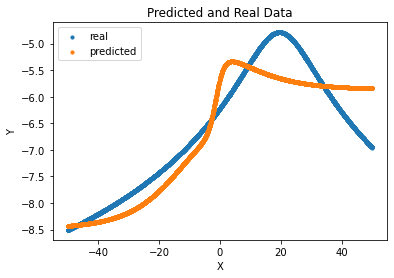

In [71]:
predicted = list()
for i in x:
    predicted.append(n3.predict(i))
    
import matplotlib.pyplot as plt

plt.scatter(df.x, df.y, label='real', s=10)
plt.scatter(df.x, predicted, label='predicted', s=10)
plt.title("Predicted and Real Data")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig('multilayer_adam_new_1.eps')

# Train 50 more epochs with smaller \alpha

In [73]:
n3.fit(train_x, train_y, 50, 0.0001, 0.9, 0.999, 10 ** -8) # Extra 50 more epochs with smaller alpha value.

Epoch 0 / 50  Loss : 3.2692133869778456e+02
Epoch 1 / 50  Loss : 3.2493667188037364e+02
Epoch 2 / 50  Loss : 3.230932300241743e+02
Epoch 3 / 50  Loss : 3.2129321931574214e+02
Epoch 4 / 50  Loss : 3.19533530170975e+02
Epoch 5 / 50  Loss : 3.1781294565975315e+02
Epoch 6 / 50  Loss : 3.1612876464171154e+02
Epoch 7 / 50  Loss : 3.1447880654293556e+02
Epoch 8 / 50  Loss : 3.1286255551799064e+02
Epoch 9 / 50  Loss : 3.112814552096844e+02
Epoch 10 / 50  Loss : 3.097386871985477e+02
Epoch 11 / 50  Loss : 3.0823863774256046e+02
Epoch 12 / 50  Loss : 3.0678618324901834e+02
Epoch 13 / 50  Loss : 3.053858973850989e+02
Epoch 14 / 50  Loss : 3.040412705239856e+02
Epoch 15 / 50  Loss : 3.0275402081535907e+02
Epoch 16 / 50  Loss : 3.015235617836502e+02
Epoch 17 / 50  Loss : 3.0034667464701454e+02
Epoch 18 / 50  Loss : 2.9921741607566025e+02
Epoch 19 / 50  Loss : 2.981272747454539e+02
Epoch 20 / 50  Loss : 2.970655726643872e+02
Epoch 21 / 50  Loss : 2.960200892050907e+02
Epoch 22 / 50  Loss : 2.9497786

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


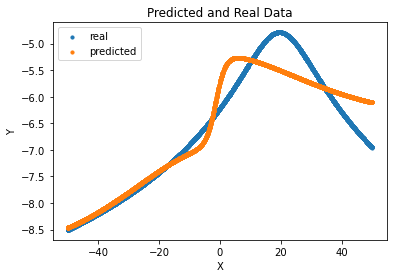

In [75]:
predicted = list()
for i in x:
    predicted.append(n3.predict(i))
    
import matplotlib.pyplot as plt

plt.scatter(df.x, df.y, label='real', s=10)
plt.scatter(df.x, predicted, label='predicted', s=10)
plt.title("Predicted and Real Data")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig('multilayer_adam_new_1.eps')

# 50 more epochs! with smaller \alpha

In [79]:
n3.fit(train_x, train_y, 50, 0.0001, 0.9, 0.999, 10 ** -8) # Extra 50 more epochs with smaller alpha value.

Epoch 0 / 50  Loss : 2.6004048964485395e+02
Epoch 1 / 50  Loss : 2.590432949932033e+02
Epoch 2 / 50  Loss : 2.58046000122269e+02
Epoch 3 / 50  Loss : 2.570438711483063e+02
Epoch 4 / 50  Loss : 2.5603616562602724e+02
Epoch 5 / 50  Loss : 2.550223961358891e+02
Epoch 6 / 50  Loss : 2.5400208152436e+02
Epoch 7 / 50  Loss : 2.529747299203423e+02
Epoch 8 / 50  Loss : 2.5193983929376424e+02
Epoch 9 / 50  Loss : 2.5089689997082965e+02
Epoch 10 / 50  Loss : 2.4984539752559414e+02
Epoch 11 / 50  Loss : 2.4878481563633767e+02
Epoch 12 / 50  Loss : 2.4771463868552993e+02
Epoch 13 / 50  Loss : 2.46634353974574e+02
Epoch 14 / 50  Loss : 2.4554345348870294e+02
Epoch 15 / 50  Loss : 2.4444143519257503e+02
Epoch 16 / 50  Loss : 2.4332780386705568e+02
Epoch 17 / 50  Loss : 2.4220207151645124e+02
Epoch 18 / 50  Loss : 2.4106375738558017e+02
Epoch 19 / 50  Loss : 2.3991238763054764e+02
Epoch 20 / 50  Loss : 2.3874749468753777e+02
Epoch 21 / 50  Loss : 2.3756861638220593e+02
Epoch 22 / 50  Loss : 2.3637529

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


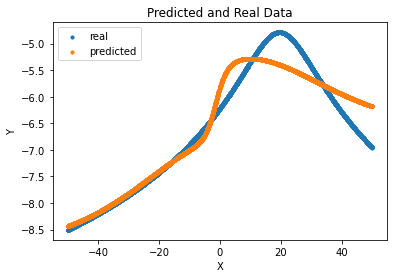

In [80]:
predicted = list()
for i in x:
    predicted.append(n3.predict(i))
    
import matplotlib.pyplot as plt

plt.scatter(df.x, df.y, label='real', s=10)
plt.scatter(df.x, predicted, label='predicted', s=10)
plt.title("Predicted and Real Data")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig('multilayer_adam_new_1.eps')

# 50 more epochs, I will go take a nap

In [81]:
n3.fit(train_x, train_y, 50, 0.0001, 0.9, 0.999, 10 ** -8) # Extra 50 more epochs with smaller alpha value.

Epoch 0 / 50  Loss : 1.9509887655936552e+02
Epoch 1 / 50  Loss : 1.932637323485901e+02
Epoch 2 / 50  Loss : 1.9139827582374417e+02
Epoch 3 / 50  Loss : 1.8950216859286724e+02
Epoch 4 / 50  Loss : 1.8757513293842544e+02
Epoch 5 / 50  Loss : 1.856169562108546e+02
Epoch 6 / 50  Loss : 1.836274945130681e+02
Epoch 7 / 50  Loss : 1.8160667563891087e+02
Epoch 8 / 50  Loss : 1.795545012627466e+02
Epoch 9 / 50  Loss : 1.774710484109344e+02
Epoch 10 / 50  Loss : 1.7535647027661025e+02
Epoch 11 / 50  Loss : 1.732109964655264e+02
Epoch 12 / 50  Loss : 1.7103493278116974e+02
Epoch 13 / 50  Loss : 1.6882866067151315e+02
Epoch 14 / 50  Loss : 1.6659263646726626e+02
Epoch 15 / 50  Loss : 1.6432739054260543e+02
Epoch 16 / 50  Loss : 1.6203352652497284e+02
Epoch 17 / 50  Loss : 1.5971172067125005e+02
Epoch 18 / 50  Loss : 1.5736272151466562e+02
Epoch 19 / 50  Loss : 1.549873498709088e+02
Epoch 20 / 50  Loss : 1.5258649927400836e+02
Epoch 21 / 50  Loss : 1.5016113689292104e+02
Epoch 22 / 50  Loss : 1.477

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


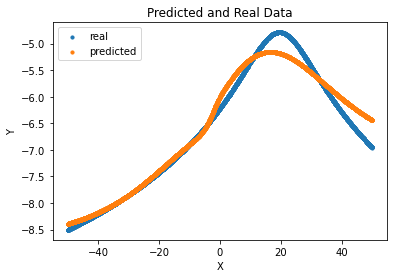

In [83]:
predicted = list()
for i in x:
    predicted.append(n3.predict(i))
    
import matplotlib.pyplot as plt

plt.scatter(df.x, df.y, label='real', s=10)
plt.scatter(df.x, predicted, label='predicted', s=10)
plt.title("Predicted and Real Data")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig('multilayer_adam_new_2.eps')

# Let's go for another round, I want this model to fit perfect

In [84]:
n3.fit(train_x, train_y, 50, 0.0001, 0.9, 0.999, 10 ** -8) # Extra 50 more epochs with smaller alpha value.

Epoch 0 / 50  Loss : 7.6648840905277e+01
Epoch 1 / 50  Loss : 7.436319872957921e+01
Epoch 2 / 50  Loss : 7.212032176843492e+01
Epoch 3 / 50  Loss : 6.992210351914241e+01
Epoch 4 / 50  Loss : 6.777023726486259e+01
Epoch 5 / 50  Loss : 6.566620639110653e+01
Epoch 6 / 50  Loss : 6.361127786163878e+01
Epoch 7 / 50  Loss : 6.1606498874313004e+01
Epoch 8 / 50  Loss : 5.9652696630400364e+01
Epoch 9 / 50  Loss : 5.775048107398348e+01
Epoch 10 / 50  Loss : 5.5900250392723585e+01
Epoch 11 / 50  Loss : 5.410219901871451e+01
Epoch 12 / 50  Loss : 5.23563278280623e+01
Epoch 13 / 50  Loss : 5.066245620974713e+01
Epoch 14 / 50  Loss : 4.9020235657239404e+01
Epoch 15 / 50  Loss : 4.742916452931273e+01
Epoch 16 / 50  Loss : 4.5888603628180874e+01
Epoch 17 / 50  Loss : 4.4397792252727044e+01
Epoch 18 / 50  Loss : 4.29558644010943e+01
Epoch 19 / 50  Loss : 4.156186481954339e+01
Epoch 20 / 50  Loss : 4.021476462246301e+01
Epoch 21 / 50  Loss : 3.891347624087734e+01
Epoch 22 / 50  Loss : 3.765686749278693e

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


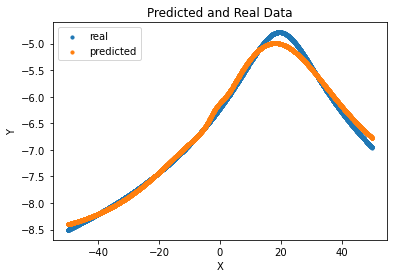

In [86]:
predicted = list()
for i in x:
    predicted.append(n3.predict(i))
    
import matplotlib.pyplot as plt

plt.scatter(df.x, df.y, label='real', s=10)
plt.scatter(df.x, predicted, label='predicted', s=10)
plt.title("Predicted and Real Data")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig('multilayer_adam_new_3.eps')

# Let's go for another round, almost there

In [88]:
n3.fit(train_x, train_y, 50, 0.0001, 0.9, 0.999, 10 ** -8) # Extra 50 more epochs with smaller alpha value.

Epoch 0 / 50  Loss : 1.616951709962574e+01
Epoch 1 / 50  Loss : 1.5756713551220358e+01
Epoch 2 / 50  Loss : 1.536060647958829e+01
Epoch 3 / 50  Loss : 1.4980529212474318e+01
Epoch 4 / 50  Loss : 1.4615828663526488e+01
Epoch 5 / 50  Loss : 1.4265866219287691e+01
Epoch 6 / 50  Loss : 1.3930018649570496e+01
Epoch 7 / 50  Loss : 1.3607679000086577e+01
Epoch 8 / 50  Loss : 1.329825743149513e+01
Epoch 9 / 50  Loss : 1.300118197524815e+01
Epoch 10 / 50  Loss : 1.271589918319886e+01
Epoch 11 / 50  Loss : 1.2441874654641232e+01
Epoch 12 / 50  Loss : 1.2178593430780557e+01
Epoch 13 / 50  Loss : 1.1925560252489971e+01
Epoch 14 / 50  Loss : 1.168229968227524e+01
Epoch 15 / 50  Loss : 1.144835609561761e+01
Epoch 16 / 50  Loss : 1.1223293550228004e+01
Epoch 17 / 50  Loss : 1.1006695544207691e+01
Epoch 18 / 50  Loss : 1.0798164675774304e+01
Epoch 19 / 50  Loss : 1.0597322218102047e+01
Epoch 20 / 50  Loss : 1.0403807623097924e+01
Epoch 21 / 50  Loss : 1.0217277967690265e+01
Epoch 22 / 50  Loss : 1.003

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


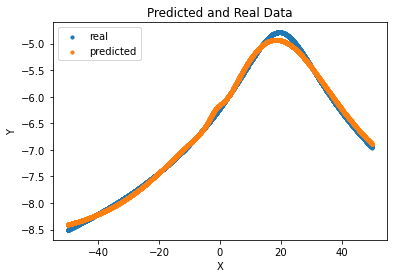

In [89]:
predicted = list()
for i in x:
    predicted.append(n3.predict(i))
    
import matplotlib.pyplot as plt

plt.scatter(df.x, df.y, label='real', s=10)
plt.scatter(df.x, predicted, label='predicted', s=10)
plt.title("Predicted and Real Data")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig('multilayer_adam_new_4.eps')

# Do one more 50 epochs!

In [90]:
n3.fit(train_x, train_y, 50, 0.0001, 0.9, 0.999, 10 ** -8) # Extra 50 more epochs with smaller alpha value.

Epoch 0 / 50  Loss : 6.79079453247965e+00
Epoch 1 / 50  Loss : 6.716779465695645e+00
Epoch 2 / 50  Loss : 6.64465600103766e+00
Epoch 3 / 50  Loss : 6.574359142644511e+00
Epoch 4 / 50  Loss : 6.5058268752561625e+00
Epoch 5 / 50  Loss : 6.438999996105672e+00
Epoch 6 / 50  Loss : 6.373821956903622e+00
Epoch 7 / 50  Loss : 6.310238715346695e+00
Epoch 8 / 50  Loss : 6.248198595635038e+00
Epoch 9 / 50  Loss : 6.18765215748789e+00
Epoch 10 / 50  Loss : 6.1285520731721705e+00
Epoch 11 / 50  Loss : 6.070853012082507e+00
Epoch 12 / 50  Loss : 6.014511532427338e+00
Epoch 13 / 50  Loss : 5.959485979600809e+00
Epoch 14 / 50  Loss : 5.9057363908404605e+00
Epoch 15 / 50  Loss : 5.853224405782349e+00
Epoch 16 / 50  Loss : 5.801913182551862e+00
Epoch 17 / 50  Loss : 5.751767319048714e+00
Epoch 18 / 50  Loss : 5.702752779093988e+00
Epoch 19 / 50  Loss : 5.654836823131015e+00
Epoch 20 / 50  Loss : 5.607987943194136e+00
Epoch 21 / 50  Loss : 5.562175801853731e+00
Epoch 22 / 50  Loss : 5.517371174896562e+0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


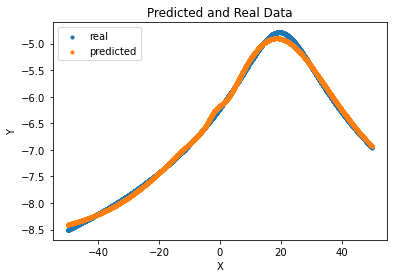

In [91]:
predicted = list()
for i in x:
    predicted.append(n3.predict(i))
    
import matplotlib.pyplot as plt

plt.scatter(df.x, df.y, label='real', s=10)
plt.scatter(df.x, predicted, label='predicted', s=10)
plt.title("Predicted and Real Data")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig('multilayer_adam_new_5.eps')

# last 50 epochs

In [92]:
n3.fit(train_x, train_y, 50, 0.0001, 0.9, 0.999, 10 ** -8) # Extra 50 more epochs with smaller alpha value.

Epoch 0 / 50  Loss : 4.5797726149399045e+00
Epoch 1 / 50  Loss : 4.555039528393987e+00
Epoch 2 / 50  Loss : 4.5307715212810455e+00
Epoch 3 / 50  Loss : 4.506957726026223e+00
Epoch 4 / 50  Loss : 4.483587576785335e+00
Epoch 5 / 50  Loss : 4.460650799427426e+00
Epoch 6 / 50  Loss : 4.438137401932323e+00
Epoch 7 / 50  Loss : 4.416037665175005e+00
Epoch 8 / 50  Loss : 4.394342134078501e+00
Epoch 9 / 50  Loss : 4.3730416091139555e+00
Epoch 10 / 50  Loss : 4.352127138136071e+00
Epoch 11 / 50  Loss : 4.331590008531962e+00
Epoch 12 / 50  Loss : 4.3114217396695835e+00
Epoch 13 / 50  Loss : 4.2916140756334915e+00
Epoch 14 / 50  Loss : 4.272158978230978e+00
Epoch 15 / 50  Loss : 4.253048620261594e+00
Epoch 16 / 50  Loss : 4.234275379027849e+00
Epoch 17 / 50  Loss : 4.215831830088171e+00
Epoch 18 / 50  Loss : 4.197710741233204e+00
Epoch 19 / 50  Loss : 4.179905066678231e+00
Epoch 20 / 50  Loss : 4.162407941460622e+00
Epoch 21 / 50  Loss : 4.145212676037981e+00
Epoch 22 / 50  Loss : 4.1283127510738

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


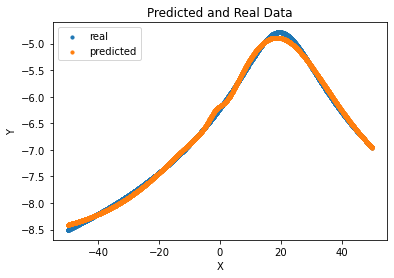

In [93]:
predicted = list()
for i in x:
    predicted.append(n3.predict(i))
    
import matplotlib.pyplot as plt

plt.scatter(df.x, df.y, label='real', s=10)
plt.scatter(df.x, predicted, label='predicted', s=10)
plt.title("Predicted and Real Data")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig('multilayer_adam_new_6.eps')

# last last 50 epochs

In [94]:
n3.fit(train_x, train_y, 50, 0.0001, 0.9, 0.999, 10 ** -8) # Extra 50 more epochs with smaller alpha value.

Epoch 0 / 50  Loss : 3.753033123359276e+00
Epoch 1 / 50  Loss : 3.7424757638534634e+00
Epoch 2 / 50  Loss : 3.7320774199373306e+00
Epoch 3 / 50  Loss : 3.721835013830678e+00
Epoch 4 / 50  Loss : 3.711745537252591e+00
Epoch 5 / 50  Loss : 3.7018060496283276e+00
Epoch 6 / 50  Loss : 3.692013676349994e+00
Epoch 7 / 50  Loss : 3.6823656070883657e+00
Epoch 8 / 50  Loss : 3.6728590941538153e+00
Epoch 9 / 50  Loss : 3.6634914509050547e+00
Epoch 10 / 50  Loss : 3.654260050201704e+00
Epoch 11 / 50  Loss : 3.645162322907044e+00
Epoch 12 / 50  Loss : 3.636195756427297e+00
Epoch 13 / 50  Loss : 3.627357893297219e+00
Epoch 14 / 50  Loss : 3.618646329804228e+00
Epoch 15 / 50  Loss : 3.6100587146511276e+00
Epoch 16 / 50  Loss : 3.601592747658559e+00
Epoch 17 / 50  Loss : 3.593246178502402e+00
Epoch 18 / 50  Loss : 3.585016805486877e+00
Epoch 19 / 50  Loss : 3.576902474352329e+00
Epoch 20 / 50  Loss : 3.56890107711561e+00
Epoch 21 / 50  Loss : 3.561010550944275e+00
Epoch 22 / 50  Loss : 3.553228877059

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


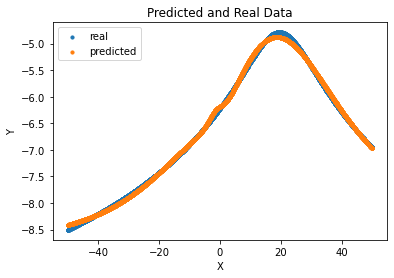

In [95]:
predicted = list()
for i in x:
    predicted.append(n3.predict(i))
    
import matplotlib.pyplot as plt

plt.scatter(df.x, df.y, label='real', s=10)
plt.scatter(df.x, predicted, label='predicted', s=10)
plt.title("Predicted and Real Data")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig('multilayer_adam_new_7.eps')